In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scanpy

In [ ]:
ROOT_PATH = '/content/drive/MyDrive/Research - Sohel sir/Pathological Cells/Pathological Cell Identification/data/Infracted Heart Border Zone - GSE214611_RAW'
PROBLEM_KEY = 'ref_0_que_1-7'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import scanpy as sc
import pandas as pd

In [ ]:
metadata_sc = pd.read_csv(f'{ROOT_PATH}/Single-Cell-Spatial-Transcriptomics-for-Border-zone/sn_wc_object_integrated@meta.data.csv', index_col=0)
metadata_sc_t = metadata_sc.rename(index=lambda x: x.split('_')[0])
metadata_sc_t['obs_names'] = metadata_sc_t.index

In [ ]:
def get_anndata(mtx_path_id, metadata_orig_id):
    PATH = f'{ROOT_PATH}/{mtx_path_id}'
    ad = sc.read_10x_mtx(PATH)
    ad.obs = ad.obs.rename(index=lambda x: x.split('-')[0])
    A = metadata_sc_t[metadata_sc_t['orig.ident'] == metadata_orig_id]

    ad.obs = ad.obs.merge(A, left_index=True, right_index=True, how='left')

    return ad

In [ ]:
def pp_anndata(ad, n_top_genes=None, plot=False):
    ad.var_names_make_unique()

    sc.pp.filter_cells(ad, min_genes=200)
    sc.pp.filter_genes(ad, min_cells=3)

    ad.var['mt'] = ad.var_names.str.startswith('mt-')
    sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    if plot:
        sc.pl.violin(ad, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                jitter=0.4, multi_panel=True)
        sc.pl.scatter(ad, x='total_counts', y='pct_counts_mt')
        sc.pl.scatter(ad, x='total_counts', y='n_genes_by_counts')

    ad = ad[ad.obs.pct_counts_mt <= 5, :]
    ad.raw = ad.copy()
    ad.layers['counts'] = ad.X.copy()

    return ad

In [ ]:
def get_mtx_path_id_metadata_orig_id(problem_key):
    exp_meta_keys = {
        'ref_0_que_1hr': {
            'reference': [
                ('snd0_1', 'D0'),
                ('snd0_2', 'D0'),
                ('snd0_3', 'NoMI_Nuclei'),
            ],
            'query': [
                ('sn1hr_1', 'sn1_1'),
                ('sn1hr_2', 'sn1_2'),
            ]
        },
        'ref_0_que_4hr': {
            'reference': [
                ('snd0_1', 'D0'),
                ('snd0_2', 'D0'),
                ('snd0_3', 'NoMI_Nuclei'),
            ],
            'query': [
                ('sn4hr', '4HR'),
            ]
        },
        'ref_0_que_1': {
            'reference': [
                ('snd0_1', 'D0'),
                ('snd0_2', 'D0'),
                ('snd0_3', 'NoMI_Nuclei'),
            ],
            'query': [
                ('snd1_1', 'D1_MI'),
                ('snd1_2', 'D1_MI_Hrt_nuclei'),
                ('snd1_3', 'D1_IR30_Hrt_nuclei'),
                ('snd1_4', 'WT_IR30_D1_2'),
                ('snd1_5', 'WT_IR30_D1_3'),
            ]
        },
        'ref_0_que_3': {
            'reference': [
                ('snd0_1', 'D0'),
                ('snd0_2', 'D0'),
                ('snd0_3', 'NoMI_Nuclei'),
            ],
            'query': [
                ('snd3_1', 'WT_IR30_D3'),
                ('snd3_2', 'D3F_M_rep1'),
                ('snd3_3', 'D3F_M_rep2'),
            ]
        },
        'ref_0_que_7': {
            'reference': [
                ('snd0_1', 'D0'),
                ('snd0_2', 'D0'),
                ('snd0_3', 'NoMI_Nuclei'),
            ],
            'query': [
                ('snd7_1', 'snD7_1'),
                ('snd7_2', 'snD7_1'),
                ('snd7_3', 'D5_D7'),
            ]
        },
        'ref_0_que_1-7': {
            'reference': [
                ('snd0_1', 'D0'),
                ('snd0_2', 'D0'),
                ('snd0_3', 'NoMI_Nuclei'),
            ],
            'query': [
                ('sn1hr_1', 'sn1_1'),
                ('sn1hr_2', 'sn1_2'),
                ('sn4hr', '4HR'),
                ('snd1_1', 'D1_MI'),
                ('snd1_2', 'D1_MI_Hrt_nuclei'),
                ('snd1_3', 'D1_IR30_Hrt_nuclei'),
                ('snd1_4', 'WT_IR30_D1_2'),
                ('snd1_5', 'WT_IR30_D1_3'),
                ('snd3_1', 'WT_IR30_D3'),
                ('snd3_2', 'D3F_M_rep1'),
                ('snd3_3', 'D3F_M_rep2'),
                ('snd7_1', 'snD7_1'),
                ('snd7_2', 'snD7_1'),
                ('snd7_3', 'D5_D7'),
            ]
        }
    }

    return exp_meta_keys[problem_key]

In [ ]:
import anndata as AD

imp_celltypes = ['Ankrd1', 'Xirp2', 'Myh6']


def get_ad(PROBLEM_KEY):

    exp_meta_keys = get_mtx_path_id_metadata_orig_id(PROBLEM_KEY)

    adatas = {}

    for key, item in exp_meta_keys.items():
        for i, (mtx_path_id, metadata_orig_id) in enumerate(item):
            ad = pp_anndata(get_anndata(mtx_path_id, metadata_orig_id))
            ad = ad[ad.obs['final_cluster'].isin(imp_celltypes)]
            dataset_id = f"{key}_{i+1}"
            ad.obs['sample'] = dataset_id
            ad.obs['dataset'] = key
            adatas[f"{key}_{i+1}"] = ad

    ad = AD.concat(adatas, label='batch_key')
    ad.obs_names_make_unique()

    cluster_to_zone = {
        "Ankrd1": "BZ1",
        "Xirp2": "BZ2",
        "Myh6": "RZ",
    }

    ad.obs["zone"] = ad.obs["final_cluster"].map(cluster_to_zone)

    return ad

In [ ]:
adata = get_ad(PROBLEM_KEY)

In [ ]:
adata

AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'

In [ ]:
!git clone https://github.com/ytanaka-bio/scIDST
!cd scIDST && pip install -r requirements.txt

fatal: destination path 'scIDST' already exists and is not an empty directory.
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [ ]:
import os
import sys
root_path = os.path.abspath('/content/scIDIST')
sys.path.insert(0, root_path )

In [ ]:
import os
import gzip
import pandas as pd
import scipy.io

output_dir = "cellranger_raw"
os.makedirs(output_dir, exist_ok=True)

# Use adata.raw if available
adata_raw = adata.raw.to_adata() if adata.raw is not None else adata

# 1. Save matrix.mtx.gz (as binary)
with gzip.open(os.path.join(output_dir, "matrix.mtx.gz"), 'wb') as f:
    scipy.io.mmwrite(f, adata_raw.X.T)  # transpose to match 10X format

# 2. Save barcodes.tsv.gz (text mode)
with gzip.open(os.path.join(output_dir, "barcodes.tsv.gz"), 'wt') as f:
    pd.DataFrame(adata_raw.obs_names).to_csv(f, sep='\t', header=False, index=False)

# 3. Save features.tsv.gz (text mode)
features = pd.DataFrame({
    'gene_id': adata_raw.var_names,
    'gene_name': adata_raw.var_names,
    'feature_type': ['Gene Expression'] * adata_raw.n_vars
})
with gzip.open(os.path.join(output_dir, "features.tsv.gz"), 'wt') as f:
    features.to_csv(f, sep='\t', header=False, index=False)

In [ ]:
ad_test = sc.read_10x_mtx("cellranger_raw")
ad_test.X[:100, :100].todense()

matrix([[ 2.,  0.,  0., ..., 12.,  0.,  1.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 1.,  4.,  0., ...,  7.,  0.,  1.],
        ...,
        [ 1.,  0.,  0., ...,  4.,  0.,  0.],
        [ 0.,  1.,  0., ...,  4.,  0.,  0.],
        [ 0.,  0.,  0., ...,  1.,  0.,  0.]], dtype=float32)

In [ ]:
!python3 "/content/scIDST/autoencoder.py" "/content/cellranger_raw/" reduced_data.csv auto_model -x 20 -t 8 -d autoencode

2025-07-24 13:40:54.313644: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-24 13:40:54.313706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-24 13:40:54.314540: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-24 13:40:54.319870: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-24 13:40:55.367866: W tensorflow/compiler/tf2

In [ ]:
import pandas as pd

df = adata.obs[['dataset']].copy()
df['disease'] = df['dataset'].map({'reference': 0, 'query': 1})
df = df[['disease']]
df.to_csv("label.csv", sep=",")

In [ ]:
!python3 "/content/scIDST/reef_analysis.py" reduced_data.csv label.csv disease -o disease_plabel.csv

Program Synthesis Train Accuracy:  0.7773851590106007
Program Synthesis Train Coverage:  1.0
Program Synthesis Validation Accuracy:  0.7672530446549392
Program Synthesis Train Accuracy:  0.7770844297421247
Program Synthesis Train Coverage:  1.0
Program Synthesis Validation Accuracy:  0.7713125845737483
Program Synthesis Train Accuracy:  0.7771596120592437
Program Synthesis Train Coverage:  1.0
Program Synthesis Validation Accuracy:  0.7699594046008119
Program Synthesis Train Accuracy:  0.7766333358394105
Program Synthesis Train Coverage:  1.0
Program Synthesis Validation Accuracy:  0.7746955345060893
Program Synthesis Train Accuracy:  0.7778362529133148
Program Synthesis Train Coverage:  1.0
Program Synthesis Validation Accuracy:  0.7645466847090663
Program Synthesis Train Accuracy:  0.7761070596195775
Program Synthesis Train Coverage:  1.0
Program Synthesis Validation Accuracy:  0.7794316644113667
Program Synthesis Train Accuracy:  0.7759566949853395
Program Synthesis Train Coverage: 

In [ ]:
!python3 "/content/scIDST/convert_label.py" -f disease -w disease_plabel.csv -p label.csv -o label_ws.csv

In [ ]:
!python3 "/content/scIDST/classifier_analysis.py" train -i reduced_data.csv -p label_ws.csv -o train -t 8 -x 20 #Generate train_model directory and train_result.csv file

2025-07-24 14:25:49.501947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-24 14:25:49.502015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-24 14:25:49.507338: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-24 14:25:49.520412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-24 14:25:50.594985: W tensorflow/compiler/tf2

In [ ]:
import pandas as pd
import scanpy as sc

df = pd.read_csv("label_ws.csv", index_col=0)  # index_col=0 uses barcodes as index
# df = pd.read_csv("train_result.csv", index_col=0)  # index_col=0 uses barcodes as index
df

In [ ]:
adata.obs["disease_score"] = df.loc[adata.obs_names, "disease"]

In [ ]:
ad_que = adata[adata.obs["dataset"] == "query"]

In [ ]:
ad_que

In [ ]:
true_labels = ad_que.obs['zone'].isin(['BZ1', 'BZ2']).to_numpy()

AUC: 0.507070702672232
AUPR: 0.47866820821670164


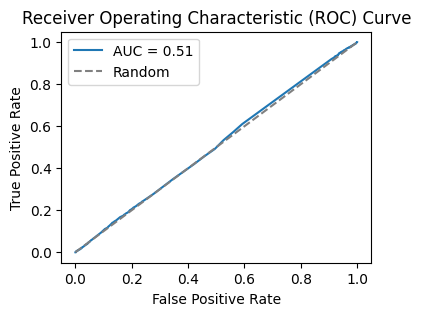

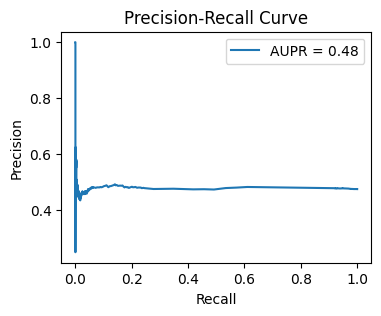

In [62]:
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

y_true = true_labels
y_scores = ad_que.obs["disease_score"]

# Calculate AUC
auc = roc_auc_score(y_true, y_scores)
print("AUC:", auc)

# Calculate AUPR
aupr = average_precision_score(y_true, y_scores)
print("AUPR:", aupr)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.savefig('auroc.svg')
plt.show()

# Plot Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
plt.figure(figsize=(4, 3))
plt.plot(recall, precision, label=f'AUPR = {aupr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig('aupr.svg')
plt.show()